## init

In [21]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex,
    sneaky_matrix as sneaky
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline

import mars



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
example = ex.cube_1
our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, a: np.ndarray, b: np.ndarray):
    super().on_faustian(s1, s2, a, b)
    print(f'faustian: {s1} {s2} {a} {b}')

(cx, cy, cz) = gridd.center_index()
cx += 2
v = vineyard2(our_complex)
state0 = v.reduce((cx, cy, cz), version=vin.Version.Sparse)
state1 = v.reduce_vine(state0, gridd.coordinate((cx+1, cy, cz)))

utils.Timed.report()

faustian: simplex v11 bd [-1] simplex v3 bd [-1] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e20 bd [13, 21] simplex e17 bd [13, 3] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e4 bd [21, 11] simplex e5 bd [11, 3] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e68 bd [11, 12] simplex e61 bd [2, 12] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e34 bd [18, 0] simplex e35 bd [0, 24] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e53 bd [20, 11] simplex e27 bd [3, 10] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e48 bd [21, 14] simplex e52 bd [13, 7] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex v21 bd [-1] simplex v11 bd [-1] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e16 bd [25, 13] simplex e15 bd [3, 25] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e13 bd [24, 12] simplex e14 bd [12, 6] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e7 bd [22, 14] simplex e8 bd [14, 7] (8, 6, 6) [0.75 0.15 0.15]
|======== Timed report ========
| reduce sparse         :      52.85ms  (52.854ms per; #1)
| red

faustian: simplex v10 bd [-1] simplex v3 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e56 bd [10, 11] simplex e27 bd [3, 10] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex v11 bd [-1] simplex v10 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex v13 bd [-1] simplex v11 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e16 bd [25, 13] simplex e17 bd [13, 3] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e4 bd [21, 11] simplex e5 bd [11, 3] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e20 bd [13, 21] simplex e15 bd [3, 25] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e28 bd [10, 25] simplex e56 bd [10, 11] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex v20 bd [-1] simplex v13 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e53 bd [20, 11] simplex e28 bd [10, 25] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex v21 bd [-1] simplex v20 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e34 bd [18, 0] simplex e35 bd [0, 24] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e68 bd [11, 12] simplex e60 bd [8, 2] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e48 bd [21, 14] simplex e52 bd [13, 7] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e57 bd [13, 16] simplex e21 bd [7, 16] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e7 bd [22, 14] simplex e8 bd [14, 7] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e26 bd [15, 24] simplex e25 bd [6, 15] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e22 bd [16, 22] simplex e57 bd [13, 16] (6, 6, 6) [0.35 0.15 0.15]



|======== Timed report ========
| reduce sparse              :     228.62ms  (228.619ms per; #1)
| vineyard.get_state_at_point:      93.00ms  ( 0.003ms per; #30492)
| reduce_vine: ordering      :   38771.85ms  ( 1.272ms per; #30492)
| from sparse                :      13.24ms  ( 2.207ms per; #6)
| mars.reduce_vine           :   33709.71ms  ( 1.106ms per; #30492)
| reduce_vine.almost-all     :   38477.03ms  ( 1.262ms per; #30492)
|==============================


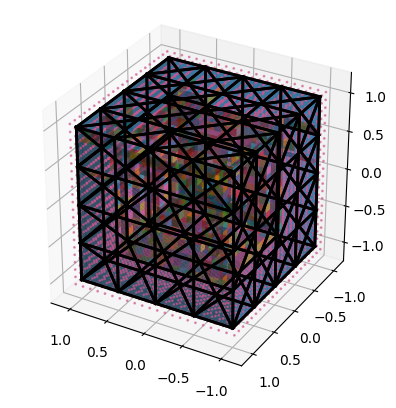

In [32]:
example = ex.cube_3_three_times_grid

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

faces = []
swaps = []
class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)
  
  def prune(self, s1: cplx.simplex, s2: cplx.simplex, point_a: np.ndarray, point_b: np.ndarray):
    swaps.append((s1, s2, point_a, point_b))
    return vin.prune_euclidean(our_complex, s1,s2,point_a, point_b, example.prune_eps)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, a: np.ndarray, b: np.ndarray):
    super().on_faustian(s1, s2, a, b)
    if s1.dim() == 0:
      c1 = gridd.cell_of(a)
      c2 = gridd.cell_of(b)
      faces.append(gridd.dual_face(c1, c2))

v = vineyard2(our_complex)

n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    v.reduce(center_point)
  else:
    old_point = gridd.coordinate(old_cell)
    old_state = v.get_state_at_point(old_point)
    new_point = gridd.coordinate(new_cell)
    v.reduce_vine(old_state, new_point)

gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=120, elev=30))
export_obj(example, our_complex, faces)

/var/folders/b4/982rm_rs7gl2xqv5pdwfzy_80000gn/T/ipykernel_5133/970500719.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


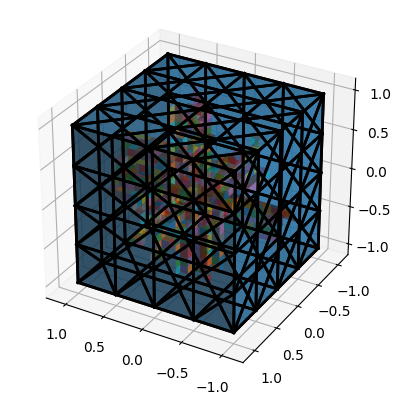

In [72]:
import math
# for eps in [5, 9.98 * 1 / math.sqrt(2), 10 / math.sqrt(2)]:
ffaces = []
for (s1, s2, a, b) in swaps:
  if vin.prune_euclidean(our_complex, s1, s2, a, b, 0):
    continue
  if s1.dim() == 1:
    c1 = gridd.cell_of(a)
    c2 = gridd.cell_of(b)
    ffaces.append(gridd.dual_face(c1, c2))
fig, ax = ourplot.plot_vineyard_results(our_complex, gridd, ffaces, CameraOpt(azim=120, elev=30), skip_grid=True)
fig.show()
export_obj(example, our_complex, ffaces)

In [67]:
export_obj(example, our_complex, ffaces)